# NYC Yellow Taxi Data
* EDA and visualization only with data from Jaunary in 2015
* Used data in BigQuery open data scource

In [2]:
import chart_studio.plotly as py
import cufflinks as cf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
print(cf.__version__)

%config InlineBackend.figure_format = 'retina'
cf.go_offline()

0.17.3


## 1. Preprocessing

In [56]:
%%time
query = """
SELECT 
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    count(*) as cnt
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015` 
WHERE EXTRACT(MONTH from pickup_datetime) = 1
GROUP BY pickup_hour
ORDER BY pickup_hour
"""

df = pd.read_gbq(query=query, dialect='standard', project_id='mobility-320516')

Downloading: 100%|██████████| 744/744 [00:00<00:00, 1631.80rows/s]

CPU times: user 45 ms, sys: 5.43 ms, total: 50.4 ms
Wall time: 2.14 s


In [57]:
df.tail(10)

,pickup_hour,cnt
734,2015-01-31 14:00:00,25059
735,2015-01-31 15:00:00,25886
736,2015-01-31 16:00:00,23822
737,2015-01-31 17:00:00,25794
738,2015-01-31 18:00:00,30804
739,2015-01-31 19:00:00,32436
740,2015-01-31 20:00:00,27555
741,2015-01-31 21:00:00,27477
742,2015-01-31 22:00:00,29862
743,2015-01-31 23:00:00,29856


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   pickup_hour  744 non-null    datetime64[ns]
 1   cnt          744 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.8 KB


- There is no outliers

## 2. Pattern

In [59]:
df = df.set_index('pickup_hour')

Text(0, 0.5, 'Demand')

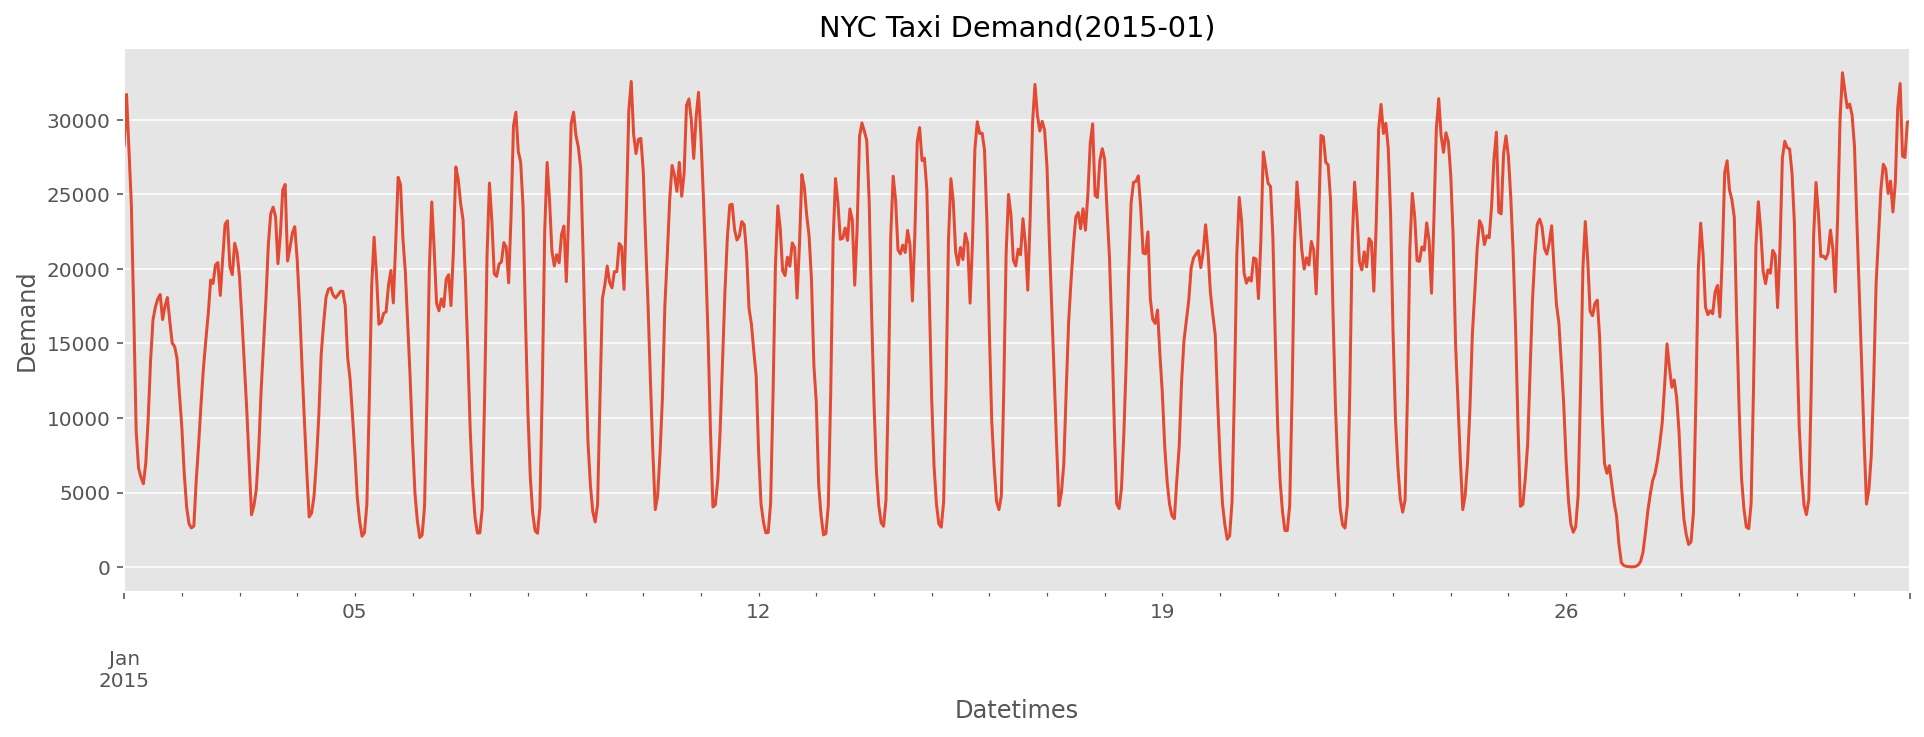

In [60]:
df.plot(title='NYC Taxi Demand(2015-01)', figsize=(16,5), legend=False)
plt.xlabel('Datetimes')
plt.ylabel('Demand')

* **Lowest demand** on Jan 27, 2015 03:00
    * due to January 2015 blizzard

### Demand by 'Date'

In [61]:
df['Date'] = df.index.date

Text(0, 0.5, 'Demand')

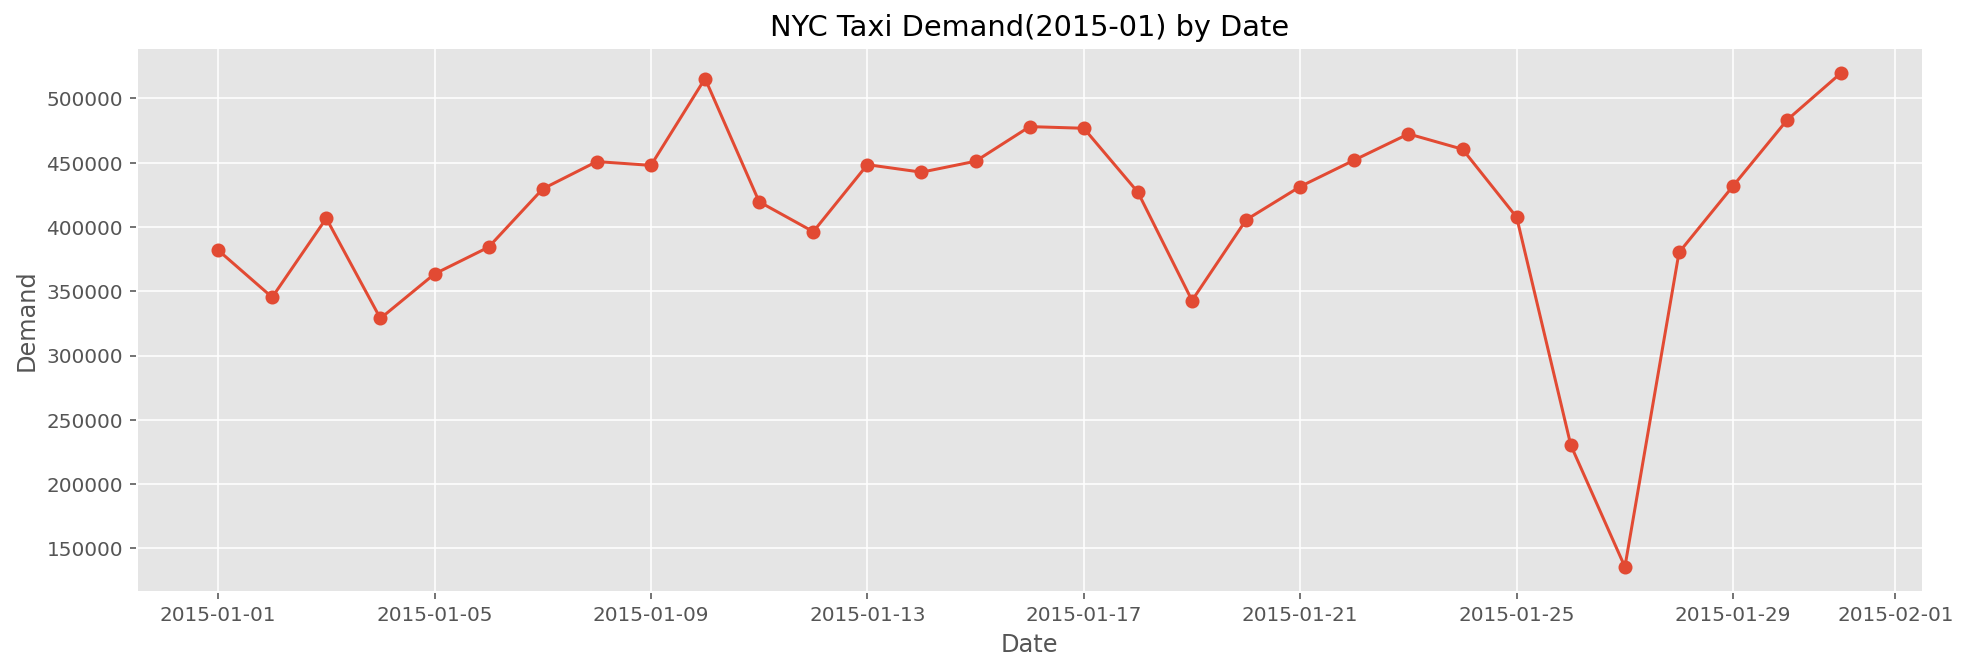

In [67]:
df.groupby('Date')[['cnt']].sum().plot(title='NYC Taxi Demand(2015-01) by Date',
                                       style='-o', legend=False, figsize=(16,5))
plt.ylabel('Demand')

### Demand by 'date' and by 'hour'

In [63]:
df['weekday'] = df.index.weekday
df['hour'] = df.index.hour
df['weeknum'] = df.index.week

In [64]:
df.head(2)

,cnt,Date,weekday,hour,weeknum
pickup_hour,,,,,
2015-01-01 00:00:00,28312,2015-01-01,3,0,1
2015-01-01 01:00:00,31707,2015-01-01,3,1,1


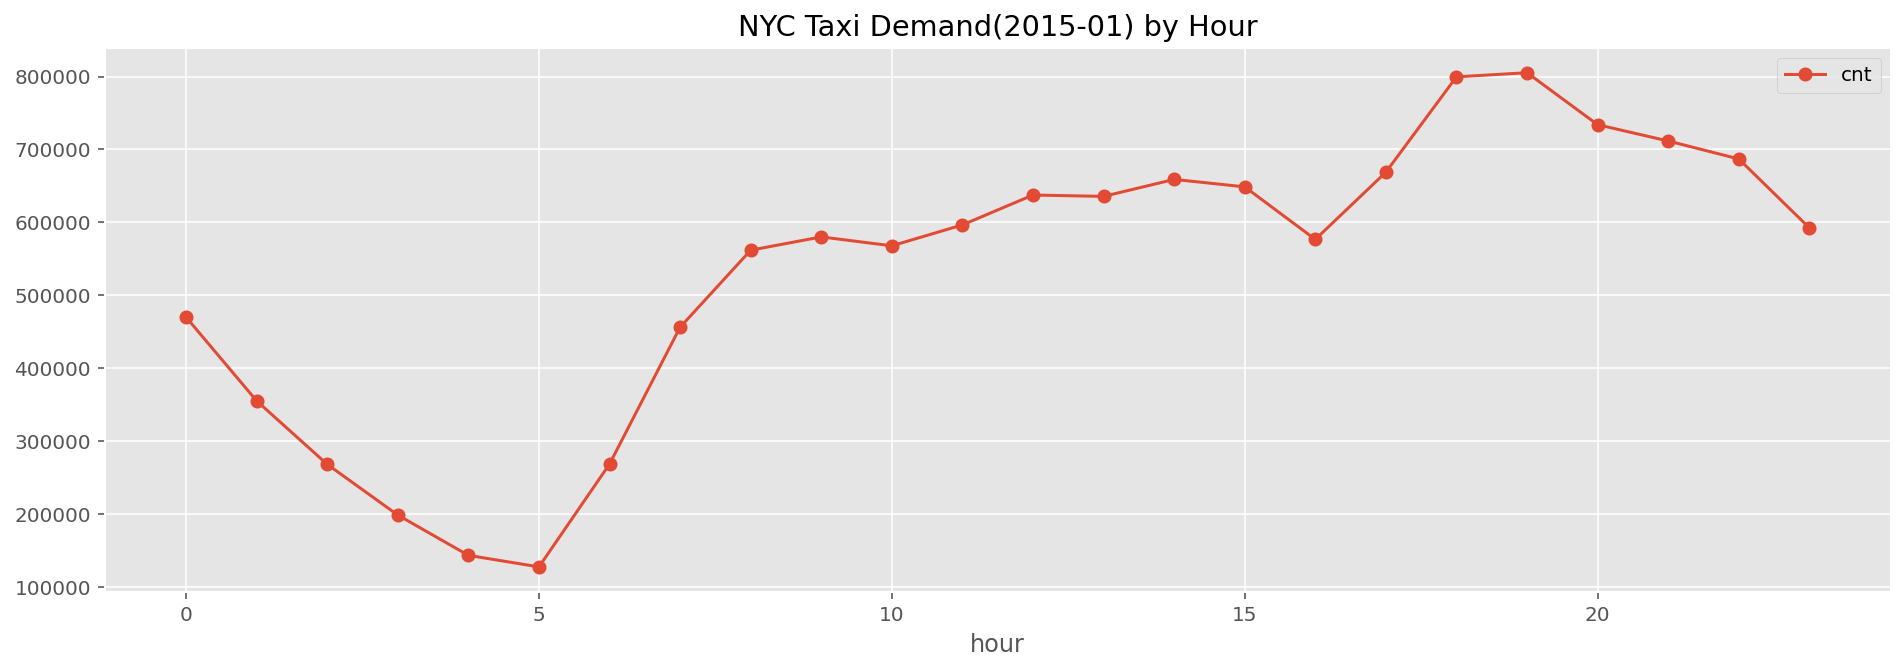

In [65]:
df.groupby('hour')[['cnt']].sum().plot(title='NYC Taxi Demand(2015-01) by Hour', style='-o', figsize=(16,5))

* **Peak Hour**: 18:00 - 19:00
* **Off-peak**: 05:00 

In [68]:
week_col = {0:"Monday",
            1:"Tuesday",
            2:"Wednesday",
            3:"Thursday",
            4:"Friday",
            5:"Saturday",
            6:"Sunday"
           }

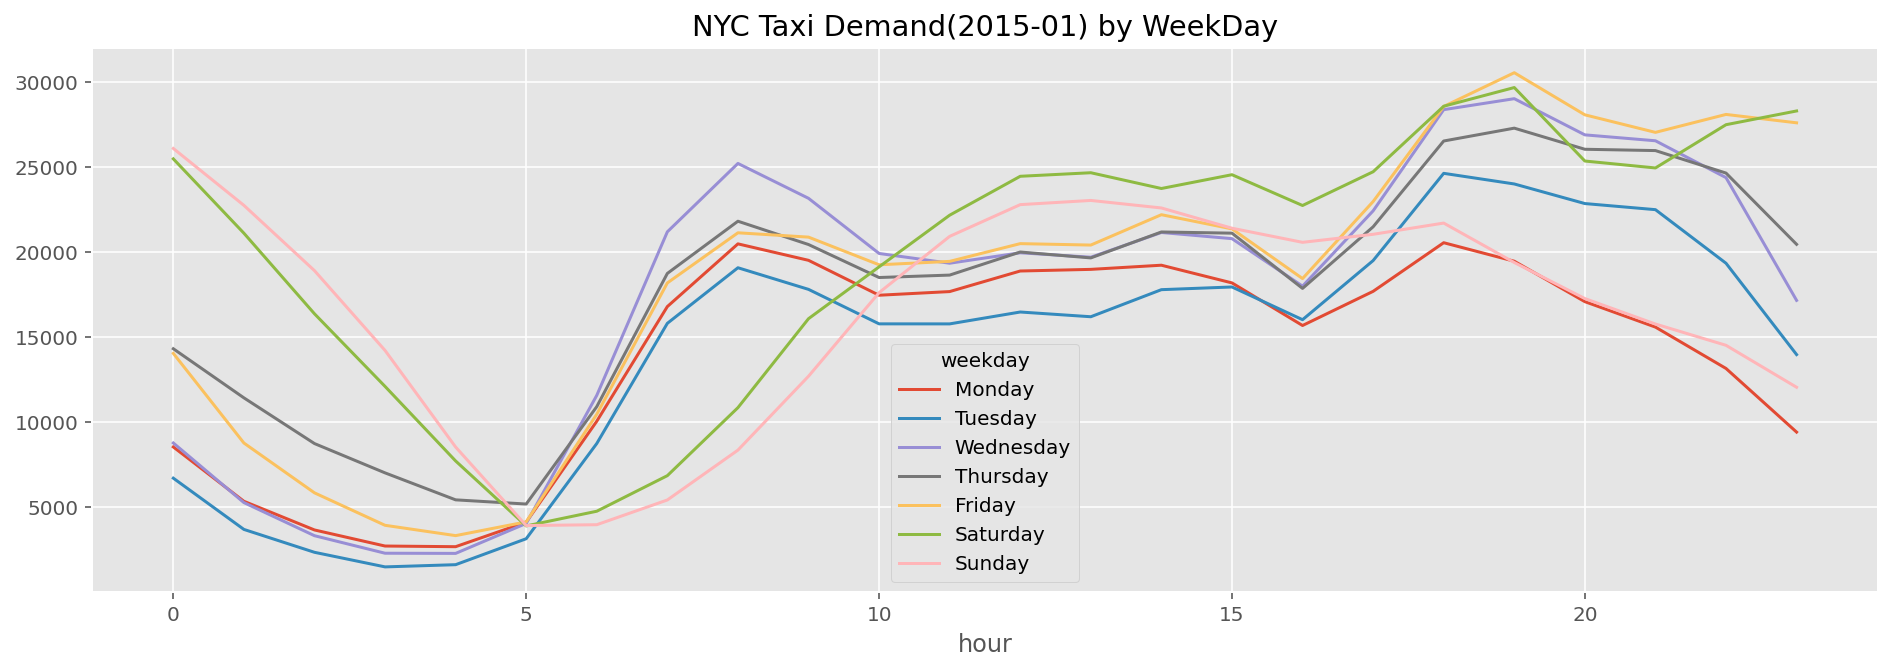

In [79]:
df[['cnt', 'hour', 'weekday']].pivot_table('cnt', index='hour', columns='weekday', aggfunc='mean')\
                                .rename(columns=week_col).plot(title='NYC Taxi Demand(2015-01) by WeekDay',
                                                               figsize=(16,5))

* There are two different trend lines between **weekday and weekend**

### Demand 'Weekday' and 'Weekend'

In [80]:
df['is_weekend'] = ((pd.DatetimeIndex(df.index).dayofweek) // 5 == 1).astype(int)

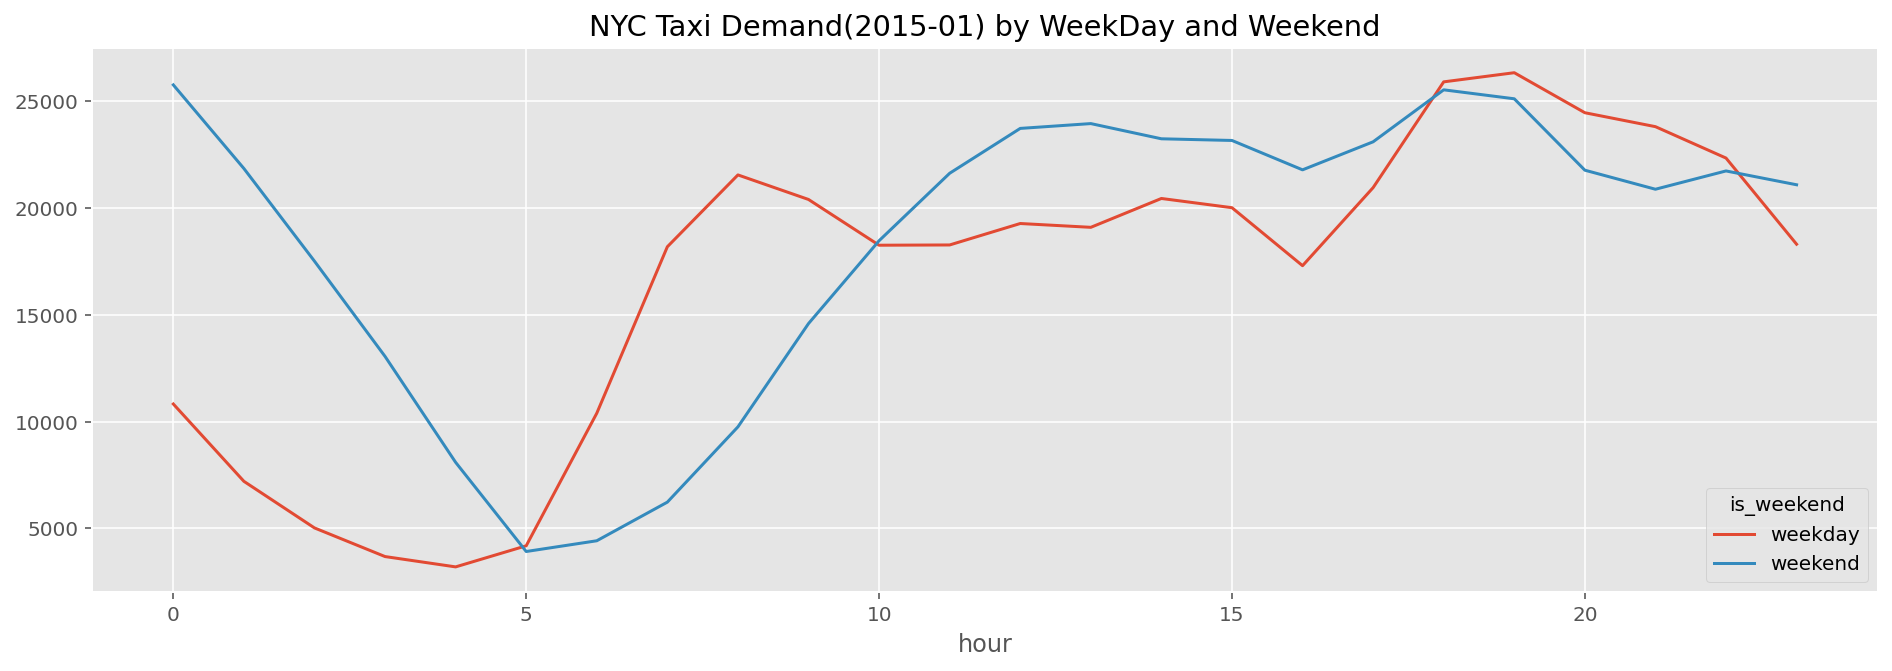

In [82]:
df.groupby(['hour', 'is_weekend'])['cnt'].mean().unstack().rename(columns={0:"weekday", 1:"weekend"})\
                .plot(title='NYC Taxi Demand(2015-01) by WeekDay and Weekend', figsize=(16,5))

* **In weekday**, The demands were rapidly increased during **05:00 - 8:00**
* **In weekend**, the demands were gradually increased during **07:00 - 12:00**
    * Highest demand on midnight

### Heatmap by 'day' and 'hour'

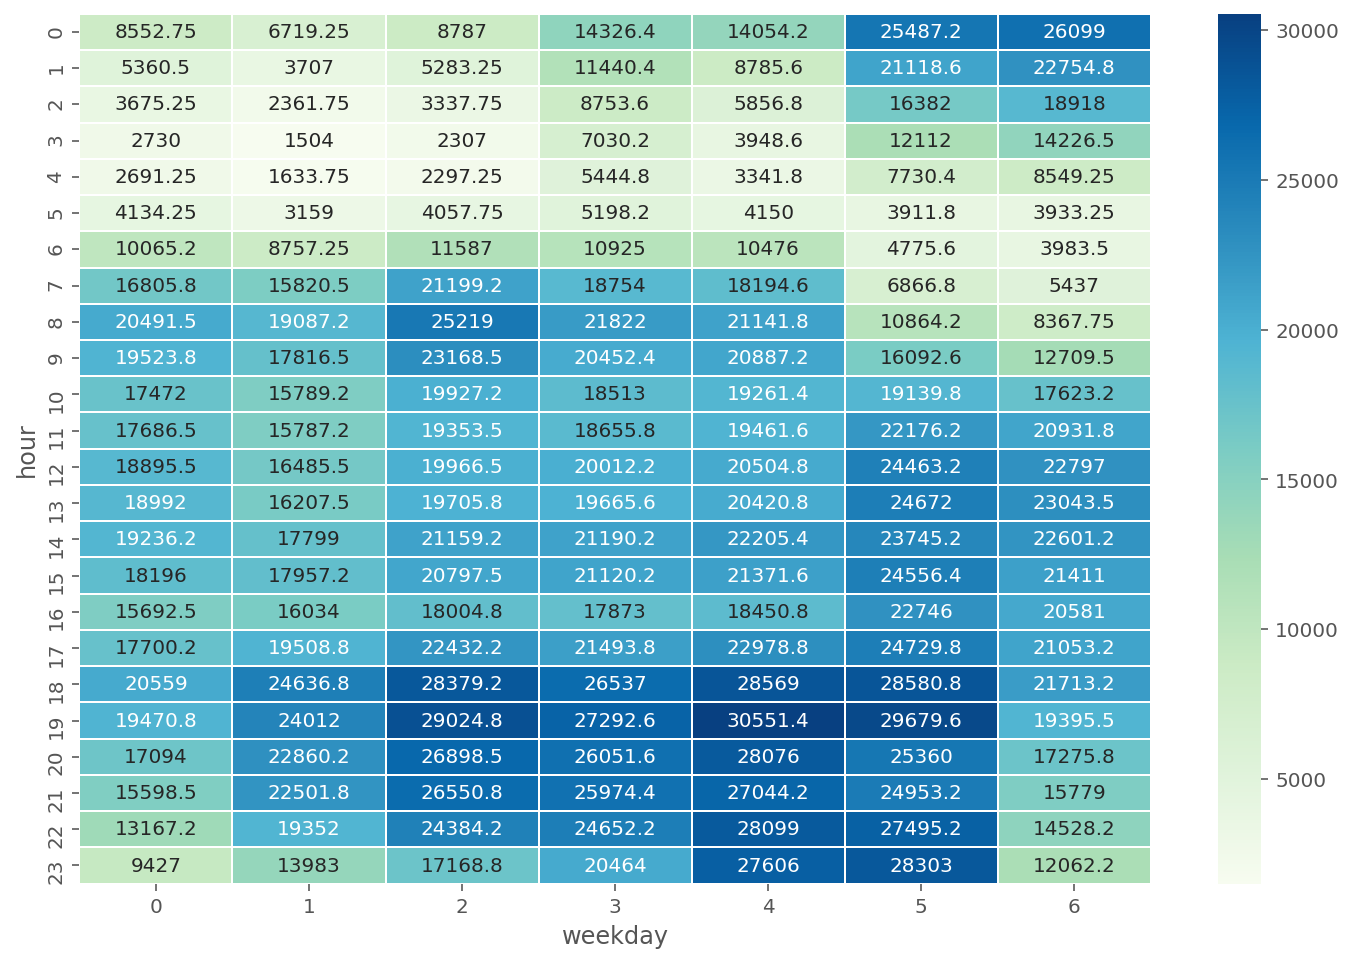

In [83]:
plt.figure(figsize=(12,8))
sns.heatmap(df.groupby(['hour', 'weekday'])['cnt'].mean().unstack(),
           lw=.5, annot=True, cmap='GnBu', fmt='g', annot_kws={'size':10});

* Demand increased at **Fiday night** and **Saturday night**

## 3. Geographical EDA

In [90]:
%%time

query = """
WITH base_data AS (
  SELECT 
    *
  FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
  WHERE EXTRACT(MONTH from pickup_datetime) = 1
), temp AS (
  SELECT nyc_taxi.*, gis.* 
  FROM (
    SELECT *
    FROM base_data
    WHERE pickup_latitude  <= 90 and pickup_latitude >= -90
    ) as nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) as gis 
  ON st_contains(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
  zip_code, 
  city,
  ST_ASTEXT(zip_code_geom) as zip_code_geom,
  DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
  count(*) as cnt
FROM temp
GROUP BY zip_code, city, zip_code_geom, pickup_hour
ORDER BY pickup_hour

"""

df = pd.read_gbq(query=query, dialect='standard', project_id='mobility-320516')

Downloading: 100%|██████████| 87020/87020 [04:52<00:00, 297.23rows/s]

CPU times: user 7.19 s, sys: 987 ms, total: 8.18 s
Wall time: 5min 22s


In [91]:
df.head()

,zip_code,city,zip_code_geom,pickup_hour,cnt
0,11218,New York city,"POLYGON((-73.991929 40.642205, -73.991734 40.6...",2015-01-01,14
1,11225,New York city,"POLYGON((-73.964786 40.662054, -73.965025 40.6...",2015-01-01,10
2,10024,New York city,"POLYGON((-73.98814 40.781409, -73.987414 40.78...",2015-01-01,869
3,11514,Carle Place CDP,"POLYGON((-73.624059 40.755152, -73.623723 40.7...",2015-01-01,1
4,10010,New York city,"POLYGON((-73.993739 40.741617, -73.994028 40.7...",2015-01-01,1045


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   zip_code       87020 non-null  object        
 1   city           87020 non-null  object        
 2   zip_code_geom  87020 non-null  object        
 3   pickup_hour    87020 non-null  datetime64[ns]
 4   cnt            87020 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 3.3+ MB


### Highest demand by 'zip code'

In [93]:
zip_code_agg_df = df.groupby(['zip_code', 'zip_code_geom'])[['cnt']].sum().reset_index()

In [94]:
zip_code_agg_df.head()

,zip_code,zip_code_geom,cnt
0,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",627563
1,10002,"POLYGON((-73.997504 40.714069, -73.9973 40.713...",234527
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598
3,10004,"MULTIPOLYGON(((-74.018008 40.705935, -74.01801...",59700
4,10005,"POLYGON((-74.012508 40.706767, -74.0124 40.706...",52454


In [95]:
zip_code_agg_df['percent'] = (zip_code_agg_df[['cnt']]/df[['cnt']].sum()).round(3).rename(columns={'cnt':'percent'})\
                                                                                    .reset_index()['percent']

In [96]:
zip_code_agg_df.tail()

,zip_code,zip_code_geom,cnt,percent
369,13656,"POLYGON((-76.067267 44.140696, -76.067236 44.1...",1,0.0
370,13691,"POLYGON((-75.88536 44.23349, -75.88501 44.2310...",1,0.0
371,14072,"MULTIPOLYGON(((-78.935536 42.965442, -78.93553...",1,0.0
372,14527,"MULTIPOLYGON(((-77.121905 42.624718, -77.12188...",1,0.0
373,14801,"POLYGON((-77.442016 42.140918, -77.44193 42.14...",1,0.0


In [97]:
filter_agg_df = zip_code_agg_df[zip_code_agg_df['percent'] > 0.000]

- Omit 0 percent (unnecessary)

In [98]:
filter_agg_df.sort_values(by='cnt', ascending=False)

,zip_code,zip_code_geom,cnt,percent
16,10019,"POLYGON((-74.003568 40.763799, -74.003767 40.7...",817267,0.066
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598,0.057
19,10022,"POLYGON((-73.977201 40.758538, -73.977655 40.7...",679831,0.055
13,10016,"POLYGON((-73.987298 40.744682, -73.987746 40.7...",663540,0.054
9,10011,"POLYGON((-74.012285 40.74387, -74.012359 40.74...",647831,0.053
...,...,...,...,...
194,11205,"POLYGON((-73.980649 40.701561, -73.980729 40.7...",8437,0.001
54,10167,"POLYGON((-73.975352 40.755303, -73.975807 40.7...",8186,0.001
45,10112,"POLYGON((-73.980426 40.759899, -73.980886 40.7...",8135,0.001
60,10173,"POLYGON((-73.979937 40.754783, -73.980395 40.7...",7966,0.001


In [99]:
filter_zip_code = filter_agg_df['zip_code'].to_list()

In [100]:
filter_agg_df.to_csv("zip_code_ratio.csv", index=False)

- Visualization using Kepler.gl
- Darker color means higher demand
<img src="https://www.dropbox.com/s/aji6c6hw5u4rsn4/Screen%20Shot%202021-08-18%20at%208.33.34%20PM.png?raw=1" width='70%'>

## 4. Finding pattern

### boxplot for demand by 'zip code'

In [101]:
zip_df = df[['zip_code', 'zip_code_geom', 'pickup_hour', 'cnt']]

In [102]:
zip_df['date'] = zip_df['pickup_hour'].dt.date

In [103]:
filter_zip_df = zip_df[zip_df['zip_code'].isin(filter_zip_code)]

In [104]:
filter_zip_daily_df = filter_zip_df.groupby(['zip_code','date'])[['cnt']].sum().reset_index()

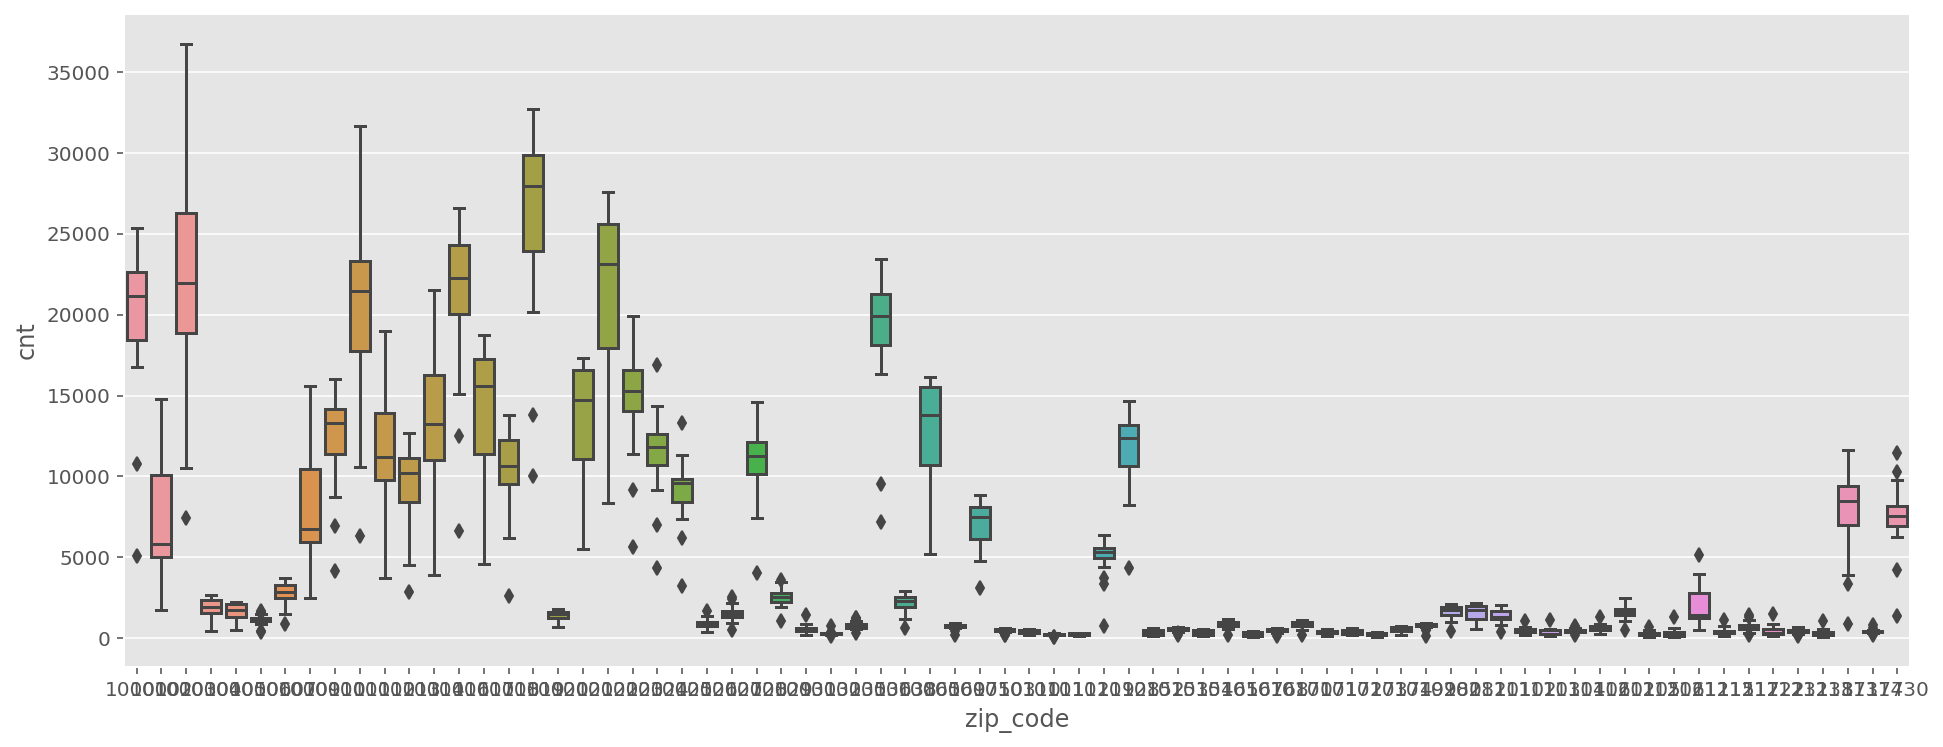

In [110]:
plt.figure(figsize=(16, 6));
sns.boxplot(x='zip_code', y='cnt', data=filter_zip_daily_df);

### Heatmap by 'date' and 'zip code'

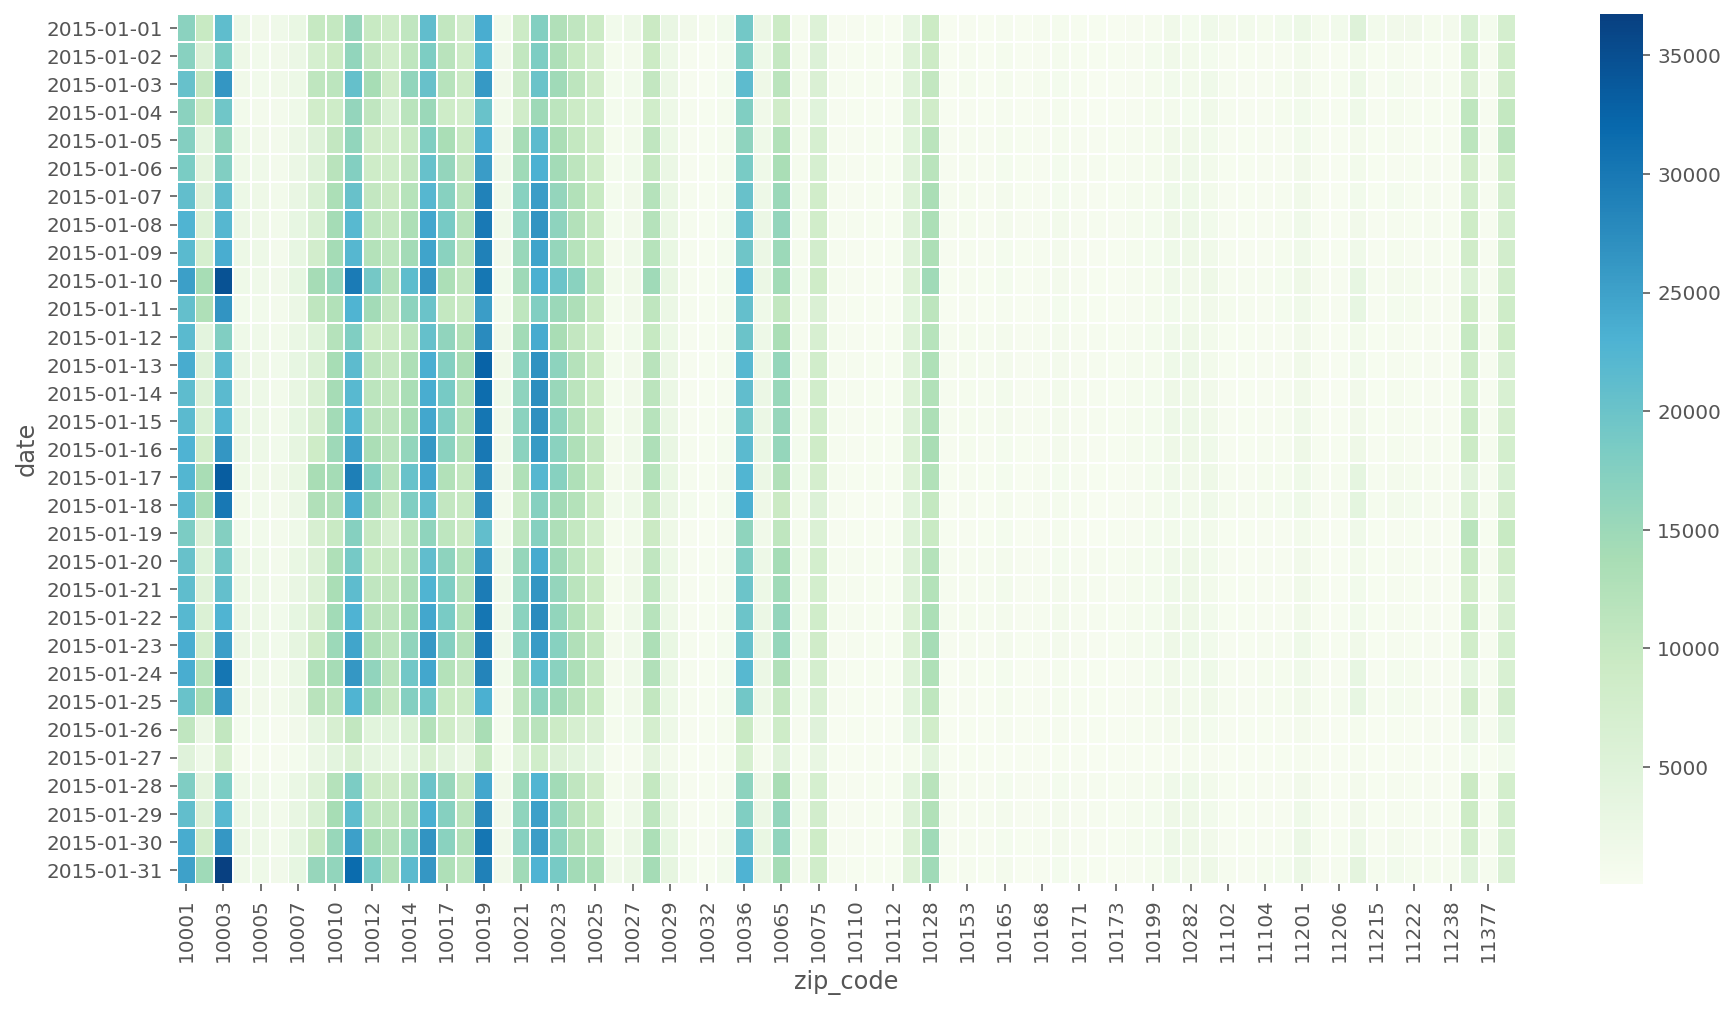

In [94]:
plt.figure(figsize=(15,8))
sns.heatmap(filter_zip_daily_df.pivot_table('cnt', index='date', columns='zip_code'),
           lw=.5, cmap='GnBu')

- Highest demand : 10019
- Next zip code : 10001, 10003, 10011, 10015, 10022
- There are pattern in 2015-01-10, 01-17, 01-24, 01-31

### Trips per zip code by hours

In [96]:
filter_zip_df['hour'] = filter_zip_df['pickup_hour'].dt.hour

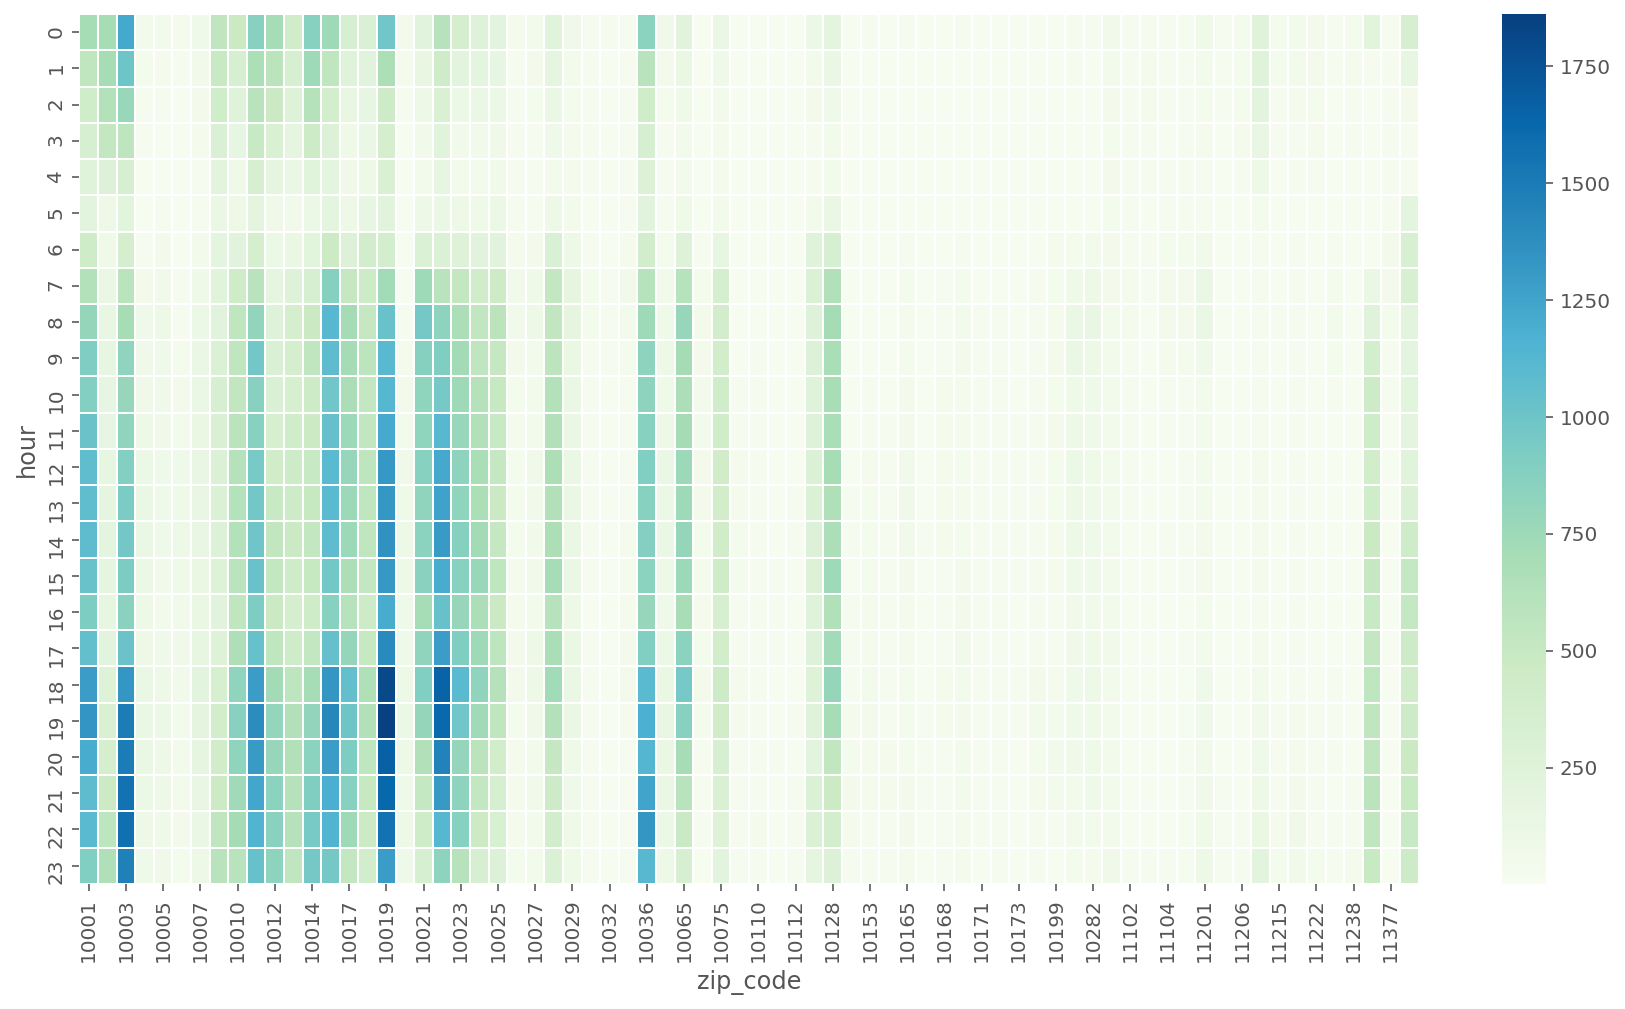

In [97]:
plt.figure(figsize=(15,8))
sns.heatmap(filter_zip_df.pivot_table('cnt', index='hour', columns='zip_code', aggfunc='mean'),
           lw=.5, cmap='GnBu')

- Higher demand between 18:00 - 22:00
- Higher demand by 'zip code' : 10001, 10003, 10011, 10015, 10019, 10022, 10036